# Load data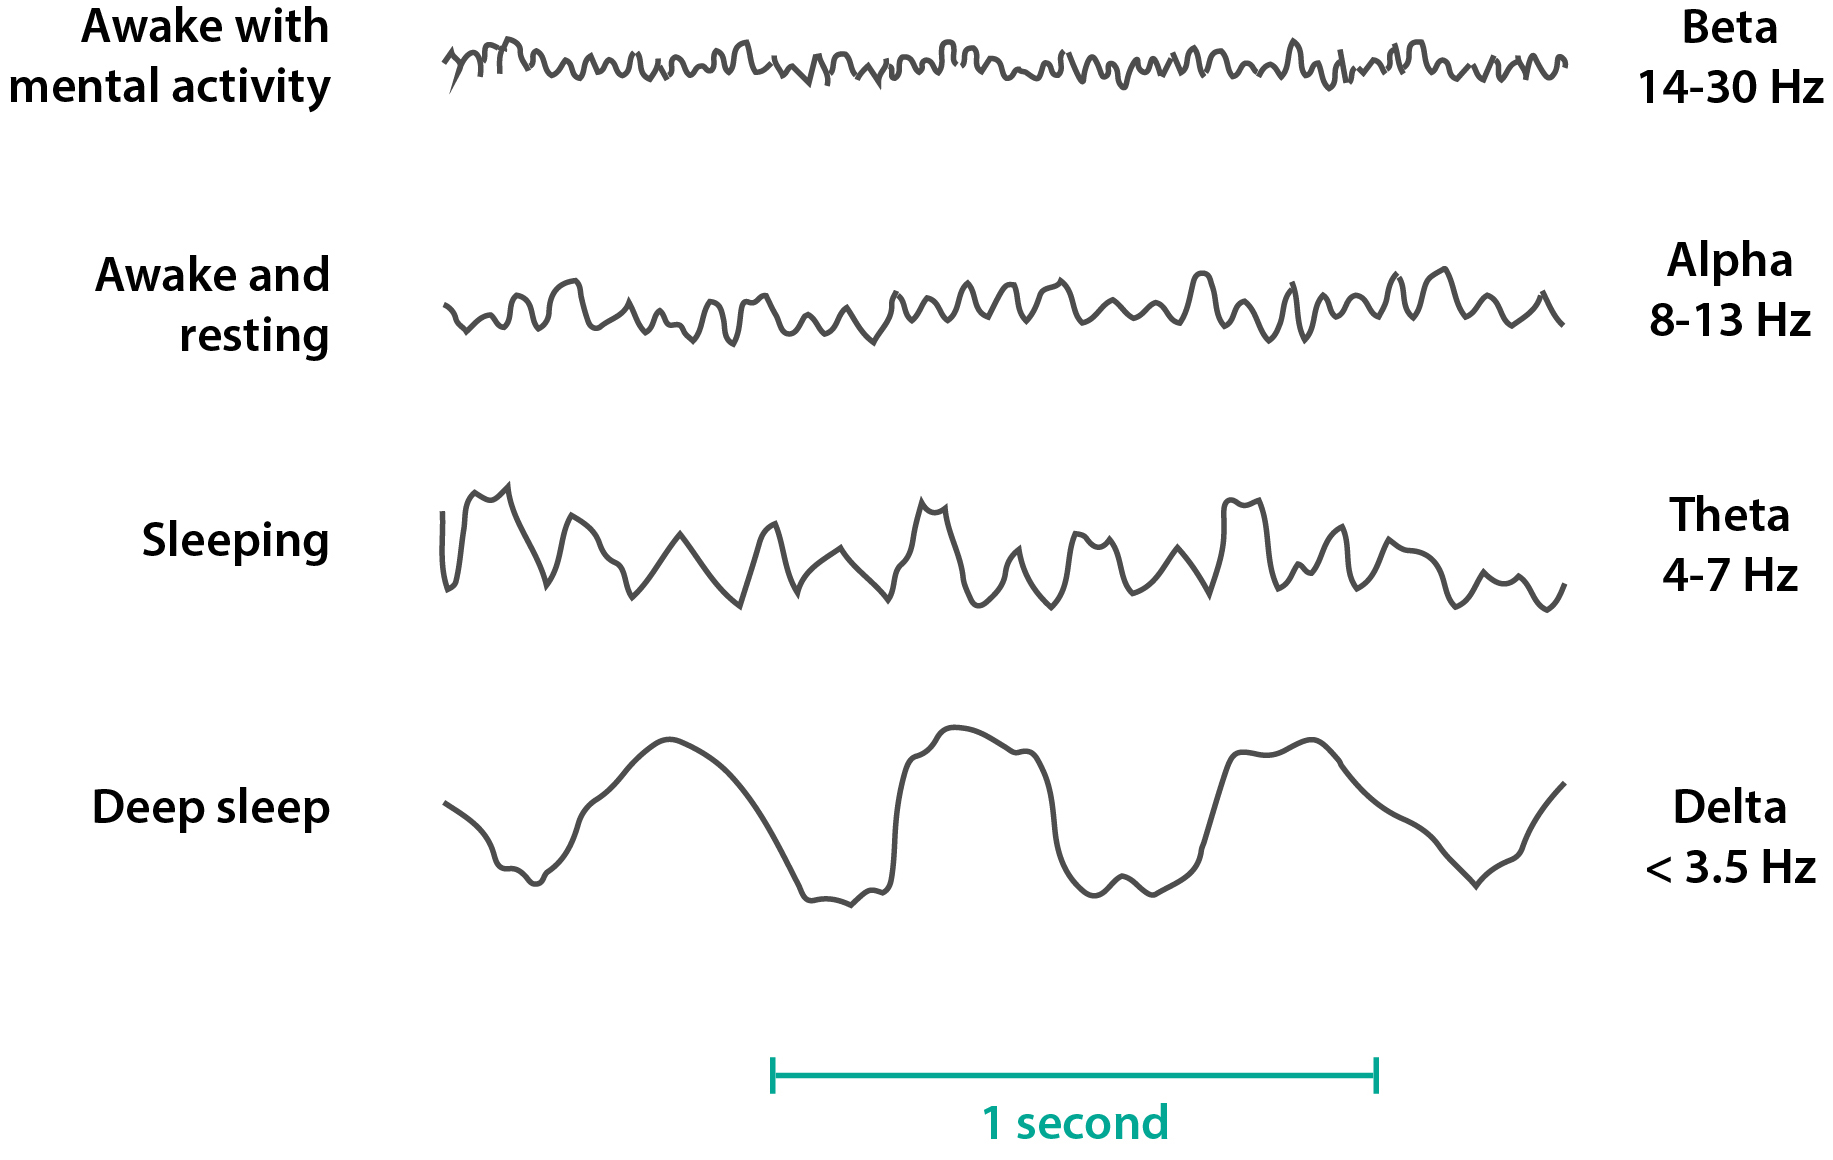

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('key')
os.environ["KAGGLE_USERNAME"] = userdata.get('username')


In [ ]:
!kaggle competitions download -c brain-motor-imagery-classification

In [ ]:
!unzip /content/brain-motor-imagery-classification.zip

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

map data

In [ ]:
train_root = "train/train"
train_index = len(train_root)+1
train_dir = os.listdir(train_root)

In [ ]:
train_data = pd.Series(train_dir).apply(lambda x:  train_root+"/"+x if "data" in x else None).dropna()
train_data

In [ ]:
train_label = pd.Series(train_dir).apply(lambda x: train_root+"/"+x if "label" in x else None).dropna()
train_label

In [ ]:
train_df = train_data.apply(lambda x: {'id': x[train_index: 14+train_index],
                                       'subject_id': x[train_index: 10+train_index],
                                       'block': x[11+train_index: 14+train_index],
                                       "type": ["series" if "series" in x else "stamps"][0], "path": x}).apply(pd.Series).set_index("id")
train_data_series_df = train_df[train_df["type"] == "stamps"].rename(columns={"path": "timestamp_path"})
train_data_timestamp_df = train_df[train_df["type"] == "series"].rename(columns={"path": "time_series_path"})["time_series_path"]

train_label_df = train_label.apply(lambda x: {'id': x[train_index: 14+train_index],
                                              'subject_id': x[train_index: 10+train_index],
                                              'block': x[11+train_index: 14+train_index],
                                              "type": ["series" if "series" in x else "stamps"][0], "path": x}).apply(pd.Series).set_index("id")
train_label_series_df = train_label_df[train_label_df["type"] == "stamps"].rename(columns={"path": "label_timestamp_path"})["label_timestamp_path"]
train_label_timestamp_df = train_label_df[train_label_df["type"] == "series"].rename(columns={"path": "label_path"})["label_path"]

all_train_df = pd.concat([train_data_series_df, train_data_timestamp_df, train_label_series_df, train_label_timestamp_df], axis=1).drop(columns='type')
all_train_df

In [ ]:
all_train_df[["label_timestamp_path", "timestamp_path"]].T.apply(lambda x: np.load(x["label_timestamp_path"]))

In [ ]:
all_train_df.iloc[0]

In [ ]:
#plot some sample of each col
timestamp_sample = np.load(all_train_df.iloc[0][2])
time_series_sample = np.load(all_train_df.iloc[0][3])
label_timestamp_sample = np.load(all_train_df.iloc[0][4])
label_path_sample = np.load(all_train_df.iloc[0][5])

In [ ]:
#check shape
timestamp_sample.shape, time_series_sample.shape, label_timestamp_sample.shape, label_path_sample.shape

## PLOT

In [ ]:
sample_train = np.load("/content/train/train/s1_d2_p002_002_data_time_series.npy")

In [ ]:
sample_train.shape

In [ ]:
tp_sample_train = np.transpose(sample_train)
tp_sample_train.shape

In [ ]:
plt.plot(sample_train[:,6])
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


np.random.seed(0)

#งงเหี้ยๆ เดี๋ยวอธิบายนะ
dt = 1/250  # sampling interval
Fs = 250  # sampling frequency
t = np.arange(0, 53714/250, dt)

s = sample_train[:,4]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(7, 7))

#plot pure signal
axes[0, 0].set_title("Signal")
axes[0, 0].plot(t, s, color='C0')
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Amplitude")

# plot fft
axes[1, 0].set_title("Magnitude Spectrum")
axes[1, 0].magnitude_spectrum(s, Fs=Fs, color='C1')

# plot in log scale
axes[1, 1].set_title("Log. Magnitude Spectrum")
axes[1, 1].magnitude_spectrum(s, Fs=Fs, scale='dB', color='C1')

axes[2, 0].set_title("Phase Spectrum ")
axes[2, 0].phase_spectrum(s, Fs=Fs, color='C2')

axes[2, 1].set_title("Angle Spectrum")
axes[2, 1].angle_spectrum(s, Fs=Fs, color='C2')

axes[0, 1].remove()

fig.tight_layout()
plt.show()

In [ ]:
#plot fourier
channel = 4
data = sample_train[:1750,channel]
# Sampling rate
Fs = 250

# Compute the FFT
fft_values = np.fft.fft(data, axis=0)  # assuming data is organized with time along axis 0
n = len(data)  # number of points in FFT

# Compute the frequency axis
freq_nosampling = np.fft.fftfreq(n, d=1)
freq = np.fft.fftfreq(n, d=1/Fs)

# Compute the magnitude spectrum (amplitude spectrum)
magnitude = np.abs(fft_values)

# Plotting only the positive frequencies
indices = freq > 0  # Filter to get only the positive frequencies
plt.figure(figsize=(10, 2))
plt.plot(freq[indices], magnitude[indices])
plt.title('Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

# do filter

Hyposthesis : <br>
1. None of any signal delay overlap the chunck
2. signal เป็นไปตามหลักการ ไม่มี signal ไหนหลุด range


---

Preprocess method :     
1. down-sampling
2. ICA
3. digital filter
4. to_spectrogram

(SL)




## load chunk data

In [ ]:
!pip install datasets

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [ ]:
from datasets import load_dataset

dataset = load_dataset("MagiBoss/EXP_NO1")

In [ ]:
dataset["train"]

In [ ]:
train_df = pd.DataFrame(dataset["train"])
train_df

In [ ]:
train_df.shape

In [ ]:
train_df["label"].unique()

In [ ]:
np.array(train_df["data"][0]).shape

In [ ]:
sigg = np.array(train_df["data"][0])
plt.plot(sigg[:,0])
plt.show()

## PSD using Welch's method

In [ ]:
idx = [0, 1, 2]
labels = ["120", "110", "150"]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

In [ ]:
fs = 250
data = np.array(train_df["data"][0])
frequencies, psd = welch(data[:,0], fs=fs, nperseg=256)

plt.figure(figsize=(10, 6))
plt.semilogy(frequencies, psd)
plt.title('Power Spectral Density (PSD)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid(True)
plt.show()

In [ ]:
#plot all labels
rows = 8
cols = 3

figure, axis = plt.subplots(rows, cols, figsize=(20, 20))

for i in range(rows):
    for j in range(cols):
        pivot = np.array(train_df["data"][j])
        frequencies, psd = welch(pivot[:,i], fs=fs, nperseg=256)
        axis[i, j].semilogy(frequencies, psd)
        if(i==0):
            axis[i, j].set_title(f"{labels[j]}")

plt.show()

In [ ]:
row_0 = train_df.index[train_df['label'] == 110].tolist()
row_1 = train_df.index[train_df['label'] == 120].tolist()
row_2 = train_df.index[train_df['label'] == 150].tolist()
labels = ["110", "120", "150"]
print(len(row_0), len(row_1), len(row_2))

rows = 8
cols = 3

figure, axis = plt.subplots(rows, cols, figsize=(20, 20))

n=0

for i in range(rows):
    for j in range(cols):
        pivot=0
        if(j==0):
            pivot = np.array(train_df["data"][row_0[n]])
        elif(j==1):
            pivot = np.array(train_df["data"][row_1[n]])
        elif(j==2):
            pivot = np.array(train_df["data"][row_2[n]])
        #frequencies, psd = welch(pivot[:,i], fs=fs, nperseg=256)
        axis[i, j].plot(pivot[:,i])
        if(i==0):
            axis[i, j].set_title(f"{labels[j]}")

plt.show()

## filter function


### down sampling

In [ ]:
#down sampling
def down_sampling(sig):
    #f = signal.resample(sig, 1750)
    signa = np.transpose(sig)
    magic_num = 2
    dx = len(sig)//magic_num
    final = np.array([signal.resample(sub_sig, dx) for sub_sig in signa])
    #print(final.shape)
    final = np.transpose(final)
    #print(final.shape)

    return final

In [ ]:
#plot test

signall = np.array(train_df["data"][0])

down_sampling_signal = down_sampling(signall)

print(signall.shape, down_sampling_signal.shape)

# plot lines
figure, axis = plt.subplots(1, 2, figsize=(10, 10))
axis[0].plot(signall[:,0])
axis[0].set_title("Original")

axis[1].plot(range(0, 1748, 2), down_sampling_signal[:,0])
axis[1].set_title("Down sampling")

# plt.plot(signall[:,0], label = "orginal")
# plt.plot(down_sampling_signal[:,0], label = "down sampling")
plt.legend()
plt.show()

### ICA

In [ ]:
#ICA

### fft->digital filter

<img src="https://images.squarespace-cdn.com/content/v1/5908027c20099e374ad3d70e/1502177644442-PG1ZBJAESW2J2FQ20V1E/eeg-waves-normal">

choose alpha and beta 8-32 Hz<br>
artifact noise 50-60 Hz

In [ ]:
#fft->digital filter

def band_pass(high_cut:int, low_cut:int, sample_rate:int, n_order:int, signal_target:np.ndarray):
    #do fft
    # fft_signal_target = np.fft.fft2(signal_target)
    # fft_signal_target = np.transpose(fft_signal_target)
    #fft_signal_target = np.fft.fft2(signal_target)
    # signal_target = np.transpose(signal_target)
    #print(fft_signal_target.shape)

    ans = []
    for i in range(8):
        sos = scipy.signal.butter(n_order, [low_cut, high_cut], 'bandpass', fs=1/sample_rate, output='sos')
        filtered_data = scipy.signal.sosfiltfilt(sos, signal_target[:, i])
        #iffft_signal_target = np.fft.ifft2(filtered_data)
        ans.append(filtered_data)

    #iffft_signal_target = np.transpose(iffft_signal_target)

    return np.transpose(np.array(ans))

In [ ]:
import scipy

In [ ]:
#plot try function

sample_signal = np.array(train_df["data"][0])
#print(sample_signal.shape)

banded_sample_signal = band_pass(32, 13, 1/250, 5, sample_signal)
print(banded_sample_signal.shape)

#freq domain
Fs = 250

fft_values1 = np.fft.fft(sample_signal, axis=0)
n1 = len(sample_signal)

freq_nosampling1 = np.fft.fftfreq(n1, d=1)
freq1 = np.fft.fftfreq(n1, d=1/Fs)

magnitude1 = np.abs(fft_values1)
indices1 = freq1 > 0

fft_values2 = np.fft.fft(banded_sample_signal, axis=0)
n2 = len(banded_sample_signal)

freq_nosampling2 = np.fft.fftfreq(n2, d=1)
freq2 = np.fft.fftfreq(n2, d=1/Fs)

magnitude2 = np.abs(fft_values2)
indices2 = freq2 > 0

#plot line time domain
# figure, axis = plt.subplots(1, 2, figsize=(12, 12))
# axis[0].plot(sample_signal[:,0])
# axis[0].set_title("Original")

# axis[1].plot(banded_sample_signal[:,0])
# axis[1].set_title("banded")

# plot lines
figure, axis = plt.subplots(2, 2, figsize=(12, 12))
axis[0, 0].plot(sample_signal[:,0])
axis[0, 0].set_title("Original")

axis[0, 1].plot(banded_sample_signal[:,0])
axis[0, 1].set_title("freq")

axis[1, 0].plot(freq1[indices1], magnitude1[indices1])
axis[1, 0].set_title("Original")

axis[1, 1].plot(freq2[indices2], magnitude2[indices2])
axis[1, 1].set_title("freq")

# plt.plot(signall[:,0], label = "orginal")
# plt.plot(down_sampling_signal[:,0], label = "down sampling")
plt.legend()
plt.show()

### short-time fourier transform

In [ ]:
import scipy

psd -> band -> stft

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

In [ ]:
sample_signal = np.array(train_df["data"][0])
sample_signal.shape

In [ ]:
banded_sample_signal = band_pass(32, 13, 1/250, 5, sample_signal)
fs = 250

In [ ]:
banded_sample_signal.shape

In [ ]:
# pow_sample_signal = np.fft.fft(pow_sample_signal)
finall = []
for chan in range(8):
    finall.append(np.fft.ifft(np.abs(np.fft.fft(banded_sample_signal[:, chan]))**2))
#pow_sample_signal = np.array([np.abs(banded_sample_signal[:, c])**2 for c in range(8)])
pow_sample_signal = np.transpose(np.array(finall))
# pow_sample_signal = np.fft.ifft(pow_sample_signal)
print(pow_sample_signal.shape)

In [ ]:
#freq domain
Fs = 250

fft_values1 = np.fft.fft(banded_sample_signal, axis=0)
n1 = len(banded_sample_signal)

freq_nosampling1 = np.fft.fftfreq(n1, d=1)
freq1 = np.fft.fftfreq(n1, d=1/Fs)

magnitude1 = np.abs(fft_values1)
indices1 = freq1 > 0

fft_values2 = np.fft.fft(pow_sample_signal, axis=0)
n2 = len(pow_sample_signal)

freq_nosampling2 = np.fft.fftfreq(n2, d=1)
freq2 = np.fft.fftfreq(n2, d=1/Fs)

magnitude2 = np.abs(fft_values2)
indices2 = freq2 > 0

#plot line time domain
# figure, axis = plt.subplots(1, 2, figsize=(12, 12))
# axis[0].plot(sample_signal[:,0])
# axis[0].set_title("Original")

# axis[1].plot(banded_sample_signal[:,0])
# axis[1].set_title("banded")

# plot lines
figure, axis = plt.subplots(2, 2, figsize=(12, 12))
axis[0, 0].plot(banded_sample_signal[:,0])
axis[0, 0].set_title("Original")

axis[0, 1].plot(pow_sample_signal[:,0])
axis[0, 1].set_title("freq")

axis[1, 0].plot(freq1[indices1], magnitude1[indices1])
axis[1, 0].set_title("Original")

axis[1, 1].plot(freq2[indices2], magnitude2[indices2])
axis[1, 1].set_title("freq")

# plt.plot(signall[:,0], label = "orginal")
# plt.plot(down_sampling_signal[:,0], label = "down sampling")
plt.legend()
plt.show()

In [ ]:
f, t, Zxx = signal.stft(banded_sample_signal[:,0], 250, nperseg=1000)
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

### to spectrogram

In [ ]:
#to_spectrogram
#sliding range

def range_time(IQ_data):
    #sliding window range time for overlap
    #total frames = input_frames - frame_lenght
    n_rd_history = 125
    frame = []
    frames = []
    for iqini in IQ_data:
        if len(frame)<n_rd_history:
            frame.append(iqini)
        else:
            frames.append(np.copy(frame))
            frame.append(iqini)
            #remove first element
            frame = frame[1::]

    return np.stack(frames)

def range_frequency(datas):
    Range_frequency_frame = []
    for data in datas:
        #time to freq domain
        rd = np.fft.fft(data, axis=0)
        #0 in center จะได้เห้นด้าน neg and pos
        #rd = np.fft.fftshift(rd, axes=0)
        #find distance
        rd = np.abs(rd)
        # turn to decible
        # 1e-10 ใส่ให้ np.log10() ข้างในไม่เป็น 0 จน undefine
        DBrd = 10 * np.log10(rd+1e-10)
        Range_frequency_frame.append(DBrd)
    return np.stack(Range_frequency_frame)

def srf_transform(complex_img, half=False):
    img = range_time(complex_img)
    #print("range_time shape :", img.shape)
    img = range_frequency(img)
    #print(img.shape)
    #print("range_freqe shape :", img.shape)
    # if half:
    #     img = img[:, :img.shape[1]//2, :]
    srf_img = img.reshape(img.shape[0]*img.shape[1], img.shape[2]).real
    #print("real shape :", srf_img.shape)
    return srf_img

In [ ]:
sample_signall = banded_sample_signal
print(sample_signall.shape)

img_sample = range_time(sample_signall)
print(img_sample.shape)

img_freq = range_frequency(img_sample)
print(img_freq.shape)

final_img = srf_transform(np.abs(sample_signall))
print(final_img.shape)

In [ ]:
#figure, axis = plt.subplots(8, 1, figsize=(5, 20))

for i in range(8):
    f, t, Sxx = signal.spectrogram(sample_signall[:, i], 250)
    #axis[i].pcolormesh(t, f, Sxx, shading='gouraud')
    print(Sxx.shape)
    print(f.shape)
    print(t.shape)

In [ ]:
plt.plot(sample_signall)

In [ ]:
f, t, Sxx = signal.spectrogram(banded_sample_signal[:,0], 250)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.title('Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
f, t, Sxx = signal.spectrogram(final_img[:, 1], 250)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

# final preprocess
scale -> down -> band -> pow -> stft

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import scipy

In [ ]:
# scaler
def scaler_better(signal_target):
    scaler = StandardScaler()
    signal_target = np.transpose(signal_target)
    all_scaled = []
    for i in range(8):
        scaled_data = scaler.fit_transform([signal_target[i]])
        print(scaled_data.shape)
        all_scaled.append(scaled_data[0])

    return np.transpose(np.array(all_scaled))

In [ ]:
sample_signal = np.array(train_df["data"][0])
scaled_sample_signal = scaler_better(sample_signal)
scaled_sample_signal.shape

In [ ]:
plt.plot(sample_signal[:, 0])

In [ ]:
plt.plot(scaled_sample_signal[:, 0])

In [ ]:
def clip_chunk(chunk):
    fix_length = 1730 # replace with min length
    trim = len(chunk) - fix_length
    # print(trim, len(chunk))
    if trim %2 == 0:
      trim_left = trim_right = int(trim/2)
      return chunk[trim_left:-trim_right]
    if trim %2 != 0:
      trim_left = trim//2 + 1
      trim_right = trim//2
      assert trim_left + trim_right == trim, 'error @clip_chunk'
      return chunk[trim_left:-trim_right]

In [ ]:
#down sampling
def down_sampling(signal_target):
    #f = signal.resample(sig, 1750)
    signa = np.transpose(signal_target)
    magic_num = 2
    dx = len(signal_target)//magic_num
    final = np.array([signal.resample(sub_sig, dx) for sub_sig in signa])
    #print(final.shape)
    final = np.transpose(final)
    #print(final.shape)

    return final

In [ ]:
# band-pass
def band_pass(high_cut:int, low_cut:int, sample_rate:int, n_order:int, signal_target:np.ndarray):
    #do fft
    # fft_signal_target = np.fft.fft2(signal_target)
    # fft_signal_target = np.transpose(fft_signal_target)
    #fft_signal_target = np.fft.fft2(signal_target)
    # signal_target = np.transpose(signal_target)
    #print(fft_signal_target.shape)

    ans = []
    for i in range(8):
        sos = scipy.signal.butter(n_order, [low_cut, high_cut], 'bandpass', fs=1/sample_rate, output='sos')
        filtered_data = scipy.signal.sosfiltfilt(sos, signal_target[:, i])
        #iffft_signal_target = np.fft.ifft2(filtered_data)
        ans.append(filtered_data)

    #iffft_signal_target = np.transpose(iffft_signal_target)

    return np.transpose(np.array(ans))

In [ ]:
# power-method
def power_method(signal_target):
    all_pow = []
    signal_target = np.transpose(signal_target)
    for chan in range(8):
        #processed_sig = np.fft.ifft(np.abs(np.fft.fft(signal_target[chan]))**2)
        fft_sig = np.abs(np.fft.fft(signal_target[chan]))
        processed_sig = fft_sig *fft_sig
        #print(processed_sig.shape)
        #all_pow.append(np.fft.ifft(np.abs(np.fft.fft(signal_target[:, chan]))**2))
        all_pow.append(np.fft.ifft(processed_sig))
    all_pow = np.transpose(np.array(all_pow))

    return all_pow

In [ ]:
sample_signal = np.array(train_df["data"][0])
clip_signal = clip_chunk(sample_signal)
print("clip_signal :", clip_signal.shape)
down_signal = down_sampling(clip_signal)
print("down shape :", down_signal.shape)
banded_signal = band_pass(32, 13, 1/125, 5, down_signal)
print("band shape :", banded_signal.shape)
pow_signal = power_method(banded_signal)
print("pow shape :", pow_signal.shape)

f, t, Zxx = signal.stft(banded_signal[:,1], 125, nperseg=865)
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

In [ ]:
#freq domain
Fs = 125

fft_values1 = np.fft.fft(banded_signal, axis=0)
n1 = len(banded_signal)

freq_nosampling1 = np.fft.fftfreq(n1, d=1)
freq1 = np.fft.fftfreq(n1, d=1/Fs)

magnitude1 = np.abs(fft_values1)
indices1 = freq1 > 0

fft_values2 = np.fft.fft(pow_signal, axis=0)
n2 = len(pow_signal)

freq_nosampling2 = np.fft.fftfreq(n2, d=1)
freq2 = np.fft.fftfreq(n2, d=1/Fs)

magnitude2 = np.abs(fft_values2)
indices2 = freq2 > 0

#plot line time domain
# figure, axis = plt.subplots(1, 2, figsize=(12, 12))
# axis[0].plot(sample_signal[:,0])
# axis[0].set_title("Original")

# axis[1].plot(banded_sample_signal[:,0])
# axis[1].set_title("banded")

# plot lines
figure, axis = plt.subplots(2, 2, figsize=(12, 12))
axis[0, 0].plot(banded_signal[:,0])
axis[0, 0].set_title("Original")

axis[0, 1].plot(pow_signal[:,0])
axis[0, 1].set_title("pow")

axis[1, 0].plot(freq1[indices1], magnitude1[indices1])
axis[1, 0].set_title("Original_freq")

axis[1, 1].plot(freq2[indices2], magnitude2[indices2])
axis[1, 1].set_title("pow_freq")

# plt.plot(signall[:,0], label = "orginal")
# plt.plot(down_sampling_signal[:,0], label = "down sampling")
plt.legend()
plt.show()

In [ ]:
plt.plot(down_signal[:,0])

In [ ]:
plt.plot(pow_signal[:,0])

## loop create

In [ ]:
!pip install tqdm

In [ ]:
!mkdir train_stft_pre

In [ ]:
from PIL import Image
from tqdm import tqdm

In [ ]:
import matplotlib
matplotlib.use('Agg')

In [ ]:
train_df.shape

In [ ]:
imgs = []
labels = []

traino = train_df.copy()

for i in tqdm(range(len(train_df))):
    pivot = np.array(train_df["data"][i])
    p_label = train_df["label"][i]
    try:
        clip_signal = clip_chunk(pivot)
        down_signal = down_sampling(clip_signal)
        banded_signal = band_pass(32, 13, 1/125, 5, down_signal)
        #pow_signal = power_method(banded_signal)

        for j in range(8):
            path = "train_stft_pre/"+f"{i}_{j}.jpg"
            f, t, Zxx = signal.stft(banded_signal[:, j], 125, nperseg=865)
            plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
            plt.savefig(path)
            img = Image.open(path)
            plt.close()
            imgs.append(img)
            labels.append(p_label)
    except:
        print(i, "i just idk how it error!")

In [ ]:
imgs[0]

# loop create dataset

In [ ]:
!pip install huggingface_hub

In [ ]:
from huggingface_hub import login
login()

In [ ]:
firstly = train_df.copy()
firstly

In [ ]:
!pip install tqdm

In [ ]:
from PIL import Image
from tqdm import tqdm
import scipy

In [ ]:
import matplotlib
matplotlib.use('Agg')

In [ ]:
!mkdir train

In [ ]:
imgs = []
labels = []

for i in tqdm(range(5754)):
    sample_signal = np.array(train_df["data"][i])
    banded_sample_signal = band_pass(32, 8, 1/250, 5,sample_signal)

    for j in range(8):
        f, t, Sxx = signal.spectrogram(banded_sample_signal[:, j], 250)
        plt.pcolormesh(t, f, Sxx, shading='gouraud')
        path = 'train/'+f'{i}_{j}.jpg'
        plt.savefig(path)
        # img = Image.open(path)
        img = np.asarray(Image.open(path))
        imgs.append(img)
        plt.close()
        labels.append(train_df["label"][i])
    # if(i==1):
    #     break

In [ ]:
len(imgs), len(labels)

In [ ]:
im = Image.fromarray(np.uint8(imgs[0]))

In [ ]:
im

In [ ]:
imgs[9] == imgs[0]

In [ ]:
imgs[9]

In [ ]:
train_spec = pd.DataFrame({"img_spec":imgs,"label":labels})

In [ ]:
train_spec.info()

In [ ]:
train_spec.to_csv("train_band_spec.csv", index=False)

In [ ]:
from datasets import Dataset
import datasets

In [ ]:
final_dataset = Dataset.from_dict({"img_spec":imgs,"label":labels})

In [ ]:
final_dataset["img_spec"][0]

In [ ]:
final_dataset.push_to_hub("Expss4/img_train_band_spec", private=True)

In [ ]:
!huggingface-cli login

### create test data

In [ ]:
import glob
len(glob.glob("/content/test/*"))

In [ ]:
glob.glob("/content/test/*")[0]

In [ ]:
all_sig = []
all_path = glob.glob("/content/test/*")
all_id = []

for i in tqdm(range(len(all_path))):
    path = all_path[i]
    sigg = np.load(path)
    idd = path.replace("/content/test/", "")
    idd = idd.replace(".npy", "")
    all_sig.append(sigg)
    all_id.append(idd)
    #print(idd, sigg.shape)
    #break

In [ ]:
len(all_sig), len(all_id)

In [ ]:
shapo = []
for i in range(len(all_sig)):
    pivot = all_sig[i]
    shapo.append(len(pivot))

In [ ]:
set(shapo)

In [ ]:
shapo_unique = list(set(shapo))
len(shapo_unique)

In [ ]:
def clip_chunk(chunk):
    fix_length = 1734 # replace with min length
    trim = len(chunk) - fix_length
    # print(trim, len(chunk))
    if trim %2 == 0:
      trim_left = trim_right = int(trim/2)
      return chunk[trim_left:-trim_right]
    if trim %2 != 0:
      trim_left = trim//2 + 1
      trim_right = trim//2
      assert trim_left + trim_right == trim, 'error @clip_chunk'
      return chunk[trim_left:-trim_right]

In [ ]:
all_sig_clip = [clip_chunk(sigg) for sigg in all_sig]

In [ ]:
len(all_sig_clip[0])

In [ ]:
!mkdir test_img

In [ ]:
imgs = []
labels = []

for i in tqdm(range(480)):
    sample_signal = np.array(all_sig_clip[i])
    banded_sample_signal = band_pass(32, 8, 1/250, 5,sample_signal)

    for j in range(8):
        f, t, Sxx = signal.spectrogram(banded_sample_signal[:, j], 250)
        plt.pcolormesh(t, f, Sxx, shading='gouraud')
        path = 'test_img/'+f'{all_id[i]}.jpg'
        plt.savefig(path)
        img = Image.open(path)
        imgs.append(img)
        plt.close()
        labels.append(all_id[i])
    # if(i==1):
    #     break

In [ ]:
final_dataset_test = Dataset.from_dict({"id":labels, "img_spec":imgs})

In [ ]:
final_dataset_test

In [ ]:
final_dataset_test["img_spec"][0]

In [ ]:
final_dataset_test.push_to_hub("Expss4/img_test_band_spec", private=True)

In [ ]:
signall = np.load("/content/test/01b63df8-05f9-4956-87f4-949ed9ae4dd6.npy")
signall.shape

In [ ]:
from datasets import load_dataset

# If the dataset is gated/private, make sure you have run huggingface-cli login
dataset = load_dataset("Expss4/img_test_band_spec")

In [ ]:
dataset

In [ ]:
dataset["train"]["img_spec"][6]

# EEGNet

In [ ]:
!pip install datasets

In [ ]:
!huggingface-cli login

In [ ]:
from datasets import load_dataset

# If the dataset is gated/private, make sure you have run huggingface-cli login
dataset = load_dataset("Expss4/train_seq_updated")

In [ ]:
train_dataset = dataset["train"]

In [ ]:
import pandas as pd

In [ ]:
train_df = pd.DataFrame(dataset["train"])

In [ ]:
train_df

In [ ]:
import torch
import numpy as np

In [ ]:
from sklearn.decomposition import FastICA
def ICA(chunk):
    X = chunk
    transformer = FastICA(n_components=8,
            random_state=0,
            whiten='unit-variance')
    X_transformed = transformer.fit_transform(X)
    # X_transformed.shape
    return X_transformed

In [ ]:
sample_signal = np.array(train_df["processed"][0])
print(sample_signal.shape)
ica_signal = ICA(sample_signal.T)
print(ica_signal.shape)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

# Step 2: Apply ICA
ica = FastICA(n_components=8)
S_ = ica.fit_transform(train_df["processed"][0])  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# Step 3: Select the signal of interest
# For demonstration, we'll assume we are interested in the first component
signal_of_interest = S_[:, 0]

# Step 4: Plot the results
plt.figure(figsize=(12, 8))

# plt.subplot(3, 1, 1)
# plt.title("Original Signals")
# plt.plot(S)

# plt.subplot(3, 1, 2)
# plt.title("Mixed Signals")
# plt.plot(X)

plt.subplot(3, 1, 3)
plt.title("ICA Recovered Signals")
plt.plot(S_)

plt.tight_layout()
plt.show()

# Plot the signal of interest separately
plt.figure(figsize=(10, 4))
plt.title("Signal of Interest (First Independent Component)")
plt.plot(signal_of_interest)
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(ica_signal[:, 0])

In [ ]:
signal = np.array([torch.tensor(j, dtype=torch.float32) for j in train_df["arr"]])
signal.shape

In [ ]:
label = []

for j in train_df["label"]:
    if(j==110):
        label.append(torch.tensor([0]))
    if(j==120):
        label.append(torch.tensor([1]))
    if(j==150):
        label.append(torch.tensor([2]))

In [ ]:
label = torch.tensor(label)
label.shape

In [ ]:
label.shape

In [ ]:
train_df["label"].value_counts()

## model

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
!pip install torchmetrics

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from torchmetrics import Accuracy

In [ ]:
#C = Channel, T = Time, F1 = n of Temporal Filter, D = Depth (n of spatial filter), F2 = n of pointwise filter

In [ ]:
fs= 125                  #sampling frequency
channel= 8            #number of electrode
num_input= 1             #number of channel picture (for EEG signal is always : 1)
num_class= 3           #number of classes
signal_length = 1730    #number of sample in each tarial

F1= 8                    #number of temporal filters
D= 3                     #depth multiplier (number of spatial filters)
F2= D*F1                 #number of pointwise filters

In [ ]:
device= 'cuda'
kernel_size_1= (1,round(fs/2))
kernel_size_2= (channel, 1)
kernel_size_3= (1, round(fs/8))
kernel_size_4= (1, 1)

kernel_avgpool_1= (1,4)
kernel_avgpool_2= (1,8)
dropout_rate= 0.2

ks0= int(round((kernel_size_1[0]-1)/2))
ks1= int(round((kernel_size_1[1]-1)/2))
kernel_padding_1= (ks0, ks1-1)
ks0= int(round((kernel_size_3[0]-1)/2))
ks1= int(round((kernel_size_3[1]-1)/2))
kernel_padding_3= (ks0, ks1)

In [ ]:
class EEGNet(nn.Module):
    def __init__(self):
        super().__init__()
        # layer 1
        self.conv2d = nn.Conv2d(num_input, F1, kernel_size_1, padding=kernel_padding_1)
        self.Batch_normalization_1 = nn.BatchNorm2d(F1)
        # layer 2
        self.Depthwise_conv2D = nn.Conv2d(F1, D*F1, kernel_size_2, groups= F1)
        self.Batch_normalization_2 = nn.BatchNorm2d(D*F1)
        self.Elu = nn.ELU()
        self.Average_pooling2D_1 = nn.AvgPool2d(kernel_avgpool_1)
        self.Dropout = nn.Dropout2d(dropout_rate)
        # layer 3
        self.Separable_conv2D_depth = nn.Conv2d( D*F1, D*F1, kernel_size_3,
                                                padding=kernel_padding_3, groups= D*F1)
        self.Separable_conv2D_point = nn.Conv2d(D*F1, F2, kernel_size_4)
        self.Batch_normalization_3 = nn.BatchNorm2d(F2)
        self.Average_pooling2D_2 = nn.AvgPool2d(kernel_avgpool_2)
        # layer 4
        self.Flatten = nn.Flatten()
        self.Dense = nn.Linear(F2*round(signal_length/64), num_class)
        self.Softmax = nn.Softmax(dim= 1)


    def forward(self, x):
        # layer 1
        y = self.Batch_normalization_1(self.conv2d(x)) #.relu()
        # layer 2
        y = self.Batch_normalization_2(self.Depthwise_conv2D(y))
        y = self.Elu(y)
        y = self.Dropout(self.Average_pooling2D_1(y))
        # layer 3
        y = self.Separable_conv2D_depth(y)
        y = self.Batch_normalization_3(self.Separable_conv2D_point(y))
        y = self.Elu(y)
        y = self.Dropout(self.Average_pooling2D_2(y))
        # layer 4
        y = self.Flatten(y)
        y = self.Dense(y)
        y = self.Softmax(y)

        return y

In [ ]:
model = EEGNet()

In [ ]:
all_signal = []
for i in range(len(signal)):
    all_signal.append(np.array([signal[i].T]))
all_signal = np.array(all_signal)

In [ ]:
all_signal.shape

In [ ]:
plt.plot(signal[0])

In [ ]:
all_signal = torch.tensor(all_signal).type(torch.float32)
all_signal.shape

In [ ]:
label = torch.tensor(label)

In [ ]:
import torch
train_batch_size= 256

dataset= TensorDataset(all_signal, label)
# Define the sizes for the train and validation sets
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset into train and validation sets
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_data_loader= DataLoader(train_dataset,
                         batch_size= train_batch_size,
                         shuffle=True)

val_data_loader= DataLoader(val_dataset,
                         batch_size= train_batch_size,
                         shuffle=True)

print("train batch size:",train_data_loader.batch_size,
     ", num of batch:", len(train_data_loader))

print("train batch size:",val_data_loader.batch_size,
     ", num of batch:", len(val_data_loader))

In [ ]:
def train_one_epoch(model, train_loader, val_data_loader, loss_fn, optimizer):
    model.train()
    loss_train = AverageMeter()
    acc_train = Accuracy(task="multiclass", num_classes= num_class)
    loss_val = AverageMeter()
    acc_val = Accuracy(task="multiclass", num_classes= num_class)

    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs
        targets = targets

        outputs = model(inputs)
        # print(outputs.shape, type(outputs))
        # print(targets[0], type(targets[0]))
        loss = loss_fn(outputs, targets)

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        optimizer.zero_grad()

        loss_train.update(loss.item())
        acc_train(outputs, targets.int())

    with torch.no_grad():
        for i, (inputs1, targets1) in enumerate(val_data_loader):
            inputs1 = inputs1
            targets1 = targets1

            outputs1 = model(inputs1)
            # print(outputs.shape, type(outputs))
            # print(targets[0], type(targets[0]))
            loss1 = loss_fn(outputs1, targets1)

            # loss1.backward()
            # nn.utils.clip_grad_norm_(model.parameters(), 1)
            # optimizer.step()
            # optimizer.zero_grad()

            loss_val.update(loss1.item())
            acc_val(outputs1, targets1.int())

    return model, loss_val.avg, acc_val.compute().item()

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
num_epochs = 79
loss_fn= nn.CrossEntropyLoss()
optimizer= optim.AdamW(model.parameters(), lr= 2e-5)

loss_train_hist = []
acc_train_hist = []

for epoch in range(num_epochs):
    model, loss_train, acc_train = train_one_epoch(model,
                                                 train_data_loader,
                                                val_data_loader,
                                                 loss_fn,
                                                 optimizer)

    loss_train_hist.append(loss_train)
    acc_train_hist.append(acc_train)

    if (epoch%10== 5)or(epoch%10== 0):
        print(f'epoch {epoch}:')
        print(f' Loss= {loss_train:.4}, Accuracy= {int(acc_train*100)}% \n')

In [ ]:
plt.plot(range(num_epochs), acc_train_hist, 'b-', label='Train')
plt.xlabel('Epoch')
plt.ylabel('acc')
plt.grid(True)
plt.legend()

In [ ]:
plt.plot(range(num_epochs), loss_train_hist, 'b-', label='Train')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# in to better data

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('key')
os.environ["KAGGLE_USERNAME"] = userdata.get('username')


In [ ]:
!kaggle competitions download -c brain-motor-imagery-classification

In [ ]:
!unzip /content/brain-motor-imagery-classification.zip

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [ ]:
df = pd.read_csv("/content/train_application/label_application.csv")
df

In [ ]:
df["label"].value_counts()

In [ ]:
all_best_data = []

for i in range(180):
    path = "/content/train_application/train/train/"+df["id"][i]+".npy"
    all_best_data.append(np.load(path))

In [ ]:
plt.plot(np.real(all_best_data[0][:,0]))